# `IbIs.ipynb`

Notebook to analyze IbIs data

- ibis notes:
- triangle wave
- 0.1 Hz
- 2 V
- set QET biases to zero and Sig Gen on
    - After SQUID Tuning
- gain 1
- Auto Zero Off

In [1]:
# imports
import sys
import os
import pickle
import ipywidgets
import importlib
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import scipy.special as ss
import scipy.optimize as so
import scipy.integrate as si
import scipy.stats as st


# custom modules
from picoscopedata import PicoscopeData
from utilities import *

find_imports()
import qetpy as qp
import optimal_filter_utils as of

In [2]:
amp = 0.37

Ib = to_ADC(amp, config = {'gain': 1})

Ib

1.5416666666666668e-05

In [3]:
import warnings
warnings.filterwarnings('ignore')
warnings.simplefilter('ignore')

In [4]:
# base location of "B13_Runs" folder
folder_base_candidates = [
    'C:/Users/MINER/Documents', # on the cryolab2 computer
    '/Volumes/B13Cryolab_Share' # connecting to shared drives from Mac
]

folder_base = find_folder('B13 Cryolab', *folder_base_candidates)
print(folder_base)

C:/Users/MINER/Documents


In [5]:
# where to find IbIs data files
runnum = 4
data_dir = folder_base + f'/B13 Cryolab/Run{runnum}/IbIs Data'
runname = '20250516'
idx = None
channels = 'ABCD' # select channel names

# will look for data files '{data_dir}/{runname}_{i}.csv' for i in idx (unless idx = None, then remove the '_{i}')

In [6]:
# read ibis data into PicoscopeData object
import picoscopedata
importlib.reload(picoscopedata)
from picoscopedata import PicoscopeData 
ibis = PicoscopeData(runname, data_dir = data_dir, idx = idx)

Created new PicoscopeData object with 82799 data points
Channels: ['A', 'B', 'C', 'D', 'H']


In [7]:
#ibis.resize(50_000, 100_000, 1)

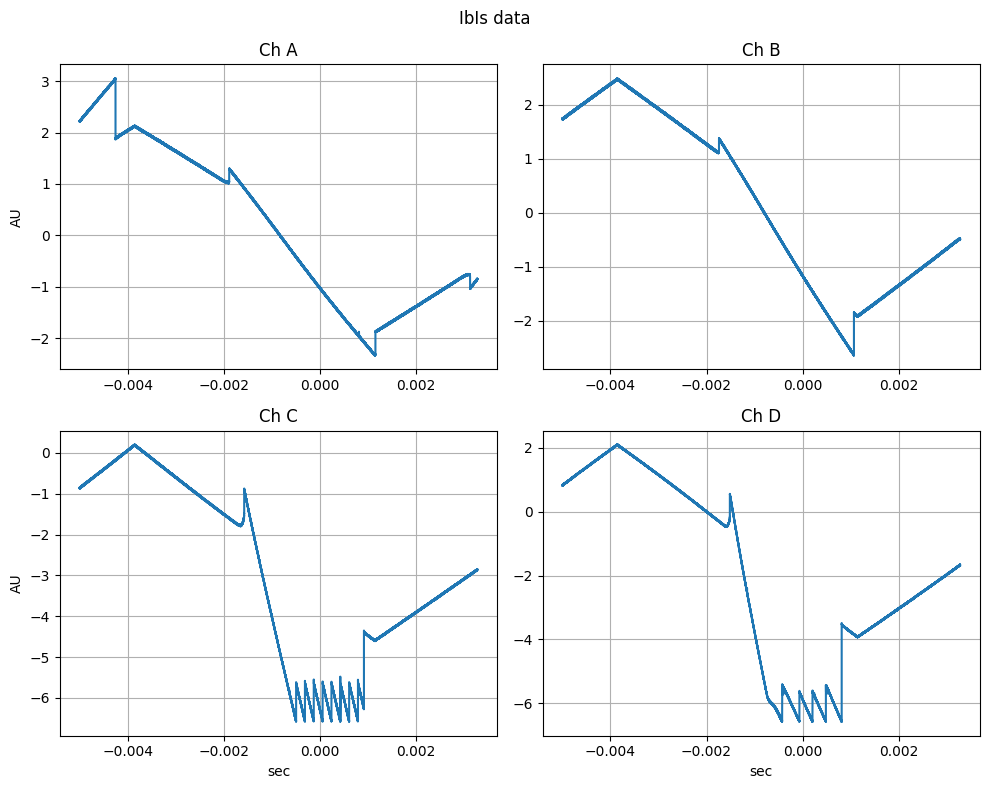

In [8]:
numrows = (1+len(channels))//2


fig, axs = plt.subplots(nrows = numrows, ncols = 2, figsize = (10,4*numrows))

fig.suptitle('IbIs data')

for ax in axs[1]:
    ax.set_xlabel('sec')
for ax in axs[:,0]:
    ax.set_ylabel('AU')

for i, (c, ax) in enumerate(zip(channels, axs.flatten())):

    ax.grid()

    ax.plot(ibis.ts, ibis(c))
    #ax.plot(ibis.ts, ibis('H'))
    ax.set_title(f'Ch {c}')

    wind = ax.axis()

    #ax.fill_betweenx((wind[2], wind[3]), 2*[ibis.ts[n1]], 2*[ibis.ts[n2]], alpha = 0.1, color = 'b')
    #ax.fill_betweenx((wind[2], wind[3]), 2*[ibis.ts[sc1]], 2*[ibis.ts[sc2]], alpha = 0.1, color = 'r')

fig.tight_layout()


In [9]:
numrows = (1+len(channels))//2

def plot_withlims(n1, n2, sc1, sc2):
    # plot IbIs data
    plt.clf()
    
    fig, axs = plt.subplots(nrows = numrows, ncols = 2, figsize = (10,4*numrows))

    fig.suptitle('IbIs data')

    for ax in axs[1]:
        ax.set_xlabel('sec')
    for ax in axs[:,0]:
        ax.set_ylabel('AU')

    for i, (c, ax) in enumerate(zip(channels, axs.flatten())):

        ax.grid()

        ax.plot(ibis.ts, ibis(c))
        ax.plot(ibis.ts, ibis('H'))
        ax.set_title(f'Ch {c}')

        wind = ax.axis()

        ax.fill_betweenx((wind[2], wind[3]), 2*[ibis.ts[n1]], 2*[ibis.ts[n2]], alpha = 0.1, color = 'b')
        ax.fill_betweenx((wind[2], wind[3]), 2*[ibis.ts[sc1]], 2*[ibis.ts[sc2]], alpha = 0.1, color = 'r')

    fig.tight_layout()

    return n1, n2, sc1, sc2

imin = 0
widge = ipywidgets.interactive(plot_withlims, n1 = (imin,ibis.N-1), n2 = (imin,ibis.N-1), sc1 = (imin,ibis.N-1), sc2 = (imin,ibis.N-1))

display(widge)


interactive(children=(IntSlider(value=41399, description='n1', max=82798), IntSlider(value=41399, description=…

In [ ]:
widge.result

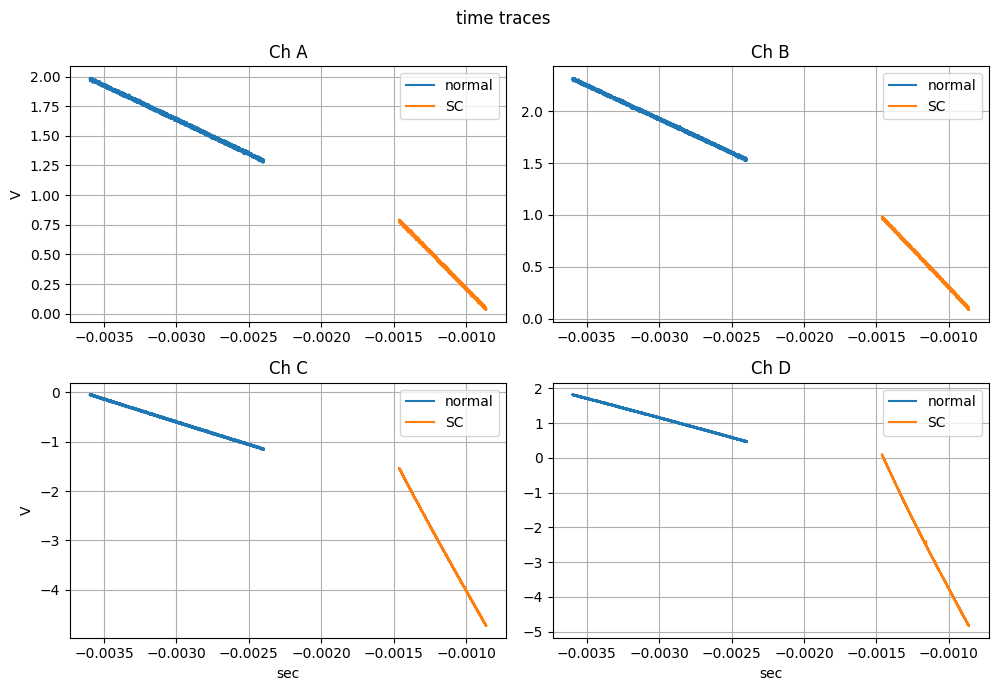

In [9]:
# normal/SC limits on IBIS data (current vs time)
n1, n2, sc1, sc2 = (14023, 26041, 35390, 41399) #widge.result

n_lims = np.array([n1, n2])
sc_lims = np.array([sc1, sc2])
all_lims = np.hstack((n_lims, sc_lims))

normalinds = range(*n_lims)
scinds = range(*sc_lims)
full_sweep = range(all_lims.min(), all_lims.max())

fig, axs = plt.subplots(nrows = numrows, ncols = 2, figsize = (10,3.5*numrows))

fig.suptitle('time traces')

for ax in axs[1]:
    ax.set_xlabel('sec')
for ax in axs[:,0]:
    ax.set_ylabel('V')

for i, (c, ax) in enumerate(zip(channels, axs.flatten())):

    ax.grid()
    ax.set_title(f'Ch {c}')


    ax.plot(ibis.ts[normalinds], ibis(c)[normalinds], label = 'normal')
    ax.plot(ibis.ts[scinds], ibis(c)[scinds], label = 'SC')

    ax.legend()

    #ax.plot(ibis(c)[nslice])
    #ax.plot(ibis(c)[scslice])


    wind = ax.axis()

    #ax.plot(ibis.ts, ibis(c))

    ax.axis(wind)
    

fig.tight_layout()


In [10]:
Ib = pico_to_ibias(43e-3, n = 4)
I_super = to_ADC(0.37, config = {'gain': 1})


print('Rp', get_Rp(Ib, I_super))
print()

Rp 0.026486486486486473



$$ Rs+Rp = RsIb/It - Rs$$

$$ R_p = R_s(I_b/I_{super}- 1)$$
$$ R_p+R_n = R_s(I_b/I_{normal}-1)$$


normal:

$$I_{tes,n} = \frac{R_s}{R_s+R_p+R_n}I_b$$

SC:

$$I_{tes,SC} = \frac{R_s}{R_s+R_p} I_b$$

with offsets $\Delta I$ and $\Delta I_b$ included for when fits don't exactly intersect at origin:


$$I_{tes,n}-\Delta I = \frac{R_s}{R_s+R_p+R_n}(I_b-\Delta I_b)$$
$$I_{tes,SC}-\Delta I = \frac{R_s}{R_s+R_p} (I_b-\Delta I_b)$$


with names in QETpy:

- $I_{tes}$ = `dites`
- $I_b$ = `ibias`
- $R_s$ = `rsh`
- $R_n$ = `rnorm`
- $R_p$ = `rp`
- $\Delta I$ = `ioff`
- $\Delta I_b$ = `ibias_off`

other parameters in QETpy:

- `rfit` = $R_n+R_p+R_s$
- `r0` - equivalent to `rnorm` but accounting for shift: `(dites - ioff) = (rsh/(rsh+rp+r0))(ibias - ibias_off)`
- `ites` = $I_{tes} - \Delta I$
- `ibias_true` = $I_b - \Delta I_b$

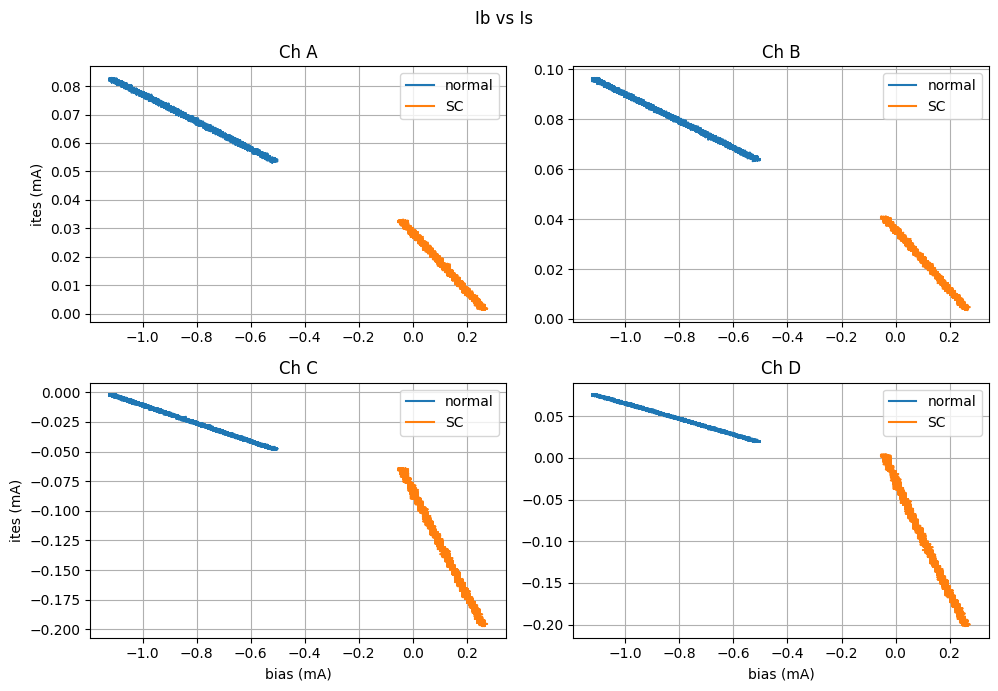

In [11]:
# normal/SC limits on IBIS data (current vs current)

fig, axs = plt.subplots(nrows = numrows, ncols = 2, figsize = (10,3.5*numrows))

fig.suptitle('Ib vs Is')

for ax in axs[1]:
    ax.set_xlabel('bias (mA)')
for ax in axs[:,0]:
    ax.set_ylabel('ites (mA)')

for i, (c, ax) in enumerate(zip(channels, axs.flatten())):

    ax.grid()
    ax.set_title(f'Ch {c}')


    ax.plot(pico_to_ibias(ibis('H')[normalinds], n = len(channels))*1e3, 1e3*to_ADC(ibis(c)[normalinds], ibis.config), label = 'normal')
    ax.plot(pico_to_ibias(ibis('H')[scinds], n = len(channels))*1e3, 1e3*to_ADC(ibis(c)[scinds], ibis.config), label = 'SC')

    ax.legend()

    #ax.plot(ibis(c)[nslice])
    #ax.plot(ibis(c)[scslice])


    wind = ax.axis()

    #ax.plot(ibis.ts, ibis(c))

    ax.axis(wind)
    

fig.tight_layout()


In [12]:
pscope_digitizer_err = 0.01#20/(2**12)

ibias = np.stack(len(channels)*[pico_to_ibias(ibis('H'), n = len(channels))])[np.newaxis,:] # A

dites = np.array([-to_ADC(ibis(c), ibis.config) for c in channels])[np.newaxis,:] # A

ivfits = qp.IBIS(
    dites = dites, 
    ibias = ibias, 
    rsh = ibis.config['rsh'], 
    rsh_err = ibis.config['rsh']/100, 
    normalinds = normalinds, 
    scinds = scinds, 
    fitsc = True,
    chan_names = list(channels),
    dites_err = np.full(ibias.shape, pscope_digitizer_err),
    ibias_err = np.full(ibias.shape, pscope_digitizer_err),
    )

ivfits.analyze()


In [13]:
ivfits.rnorm # normal state resistances (Ohms)

array([[0.22262693, 0.20789586, 0.21650746, 0.18542144]])

In [14]:
ivfits.rp # parasitic resistances (Ohms)

array([[0.17644424, 0.14619476, 0.0259543 , 0.00979551]])

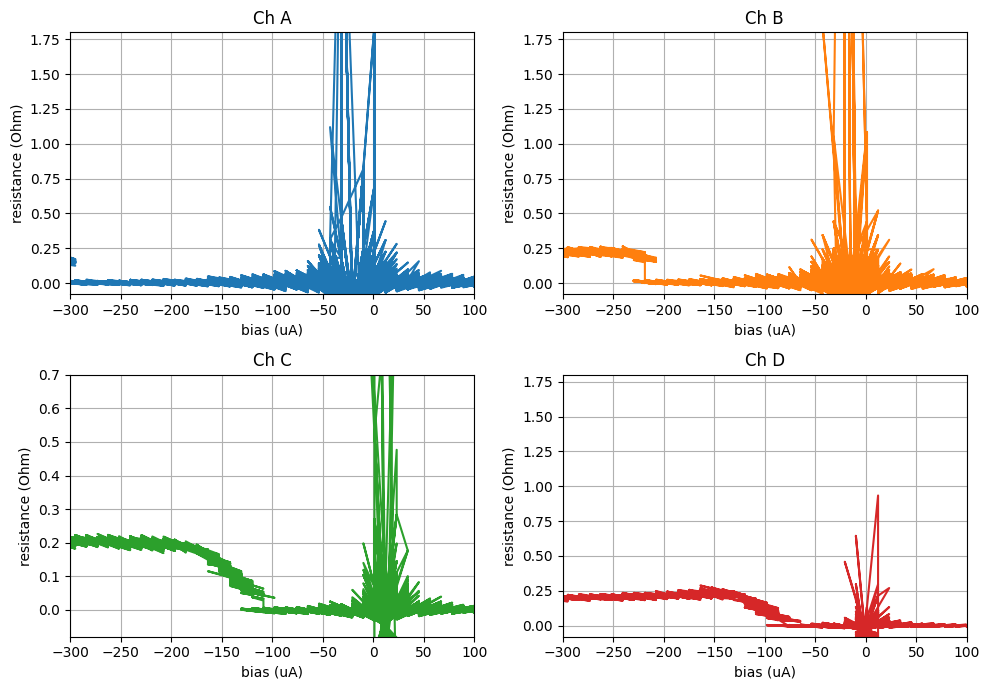

In [15]:
fig, axs = plt.subplots(nrows = numrows, ncols = 2, figsize = (10,3.5*numrows))

for i, (c,ax) in enumerate(zip(channels, axs.flatten())):
    ax.grid()
    ax.set_title(f'Ch {c}')
    ax.plot(ibis('H')[full_sweep]*1e3, ivfits.r0[0,i][full_sweep], label = c, color = f'C{i}')
    ax.set_ylim(-0.08, 0.7 if c == 'C' else 1.8)
    ax.set_xlim(-300, 100)
    ax.set_xlabel('bias (uA)')
    ax.set_ylabel('resistance (Ohm)')

#plt.legend(loc = 'best')
fig.tight_layout()

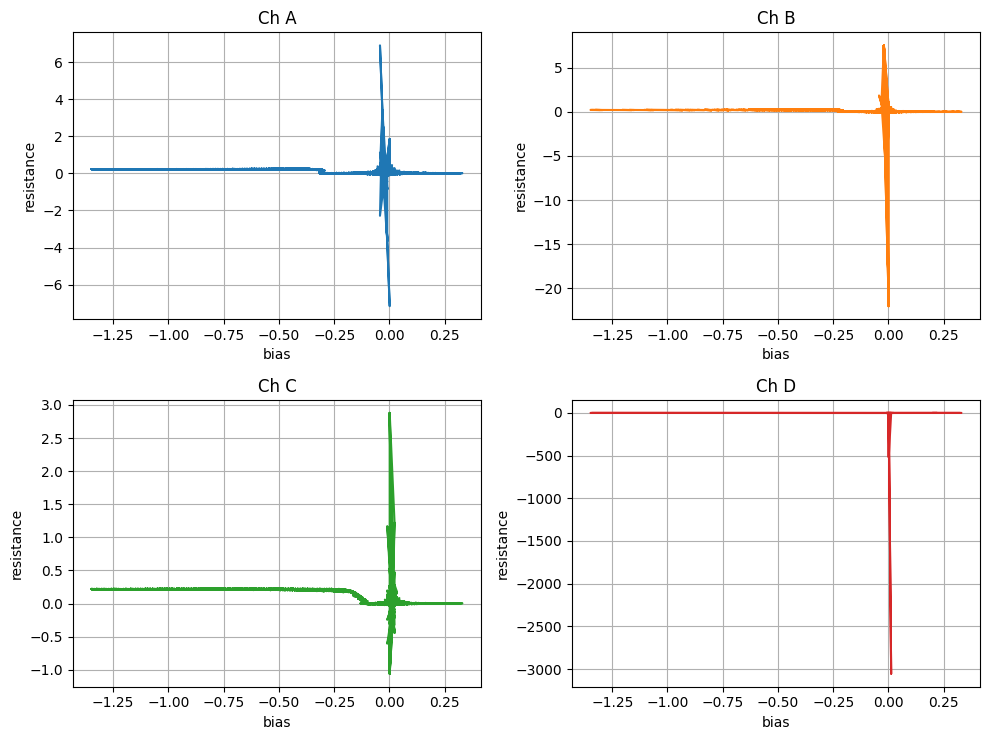

In [16]:
fig, axs = plt.subplots(nrows = 2, ncols = 2, figsize = (10,7.5))

for i, (c,ax) in enumerate(zip(channels, axs.flatten())):
    ax.grid()
    ax.set_title(f'Ch {c}')
    ax.plot(ibis('H')[full_sweep], ivfits.r0[0,i][full_sweep], label = c, color = f'C{i}')
    #ax.set_ylim(-0.1, 0.1)
    ax.set_xlabel('bias')
    ax.set_ylabel('resistance')

#plt.legend(loc = 'best')
fig.tight_layout()

In [17]:
ivfits.rnorm

array([[0.22262693, 0.20789586, 0.21650746, 0.18542144]])

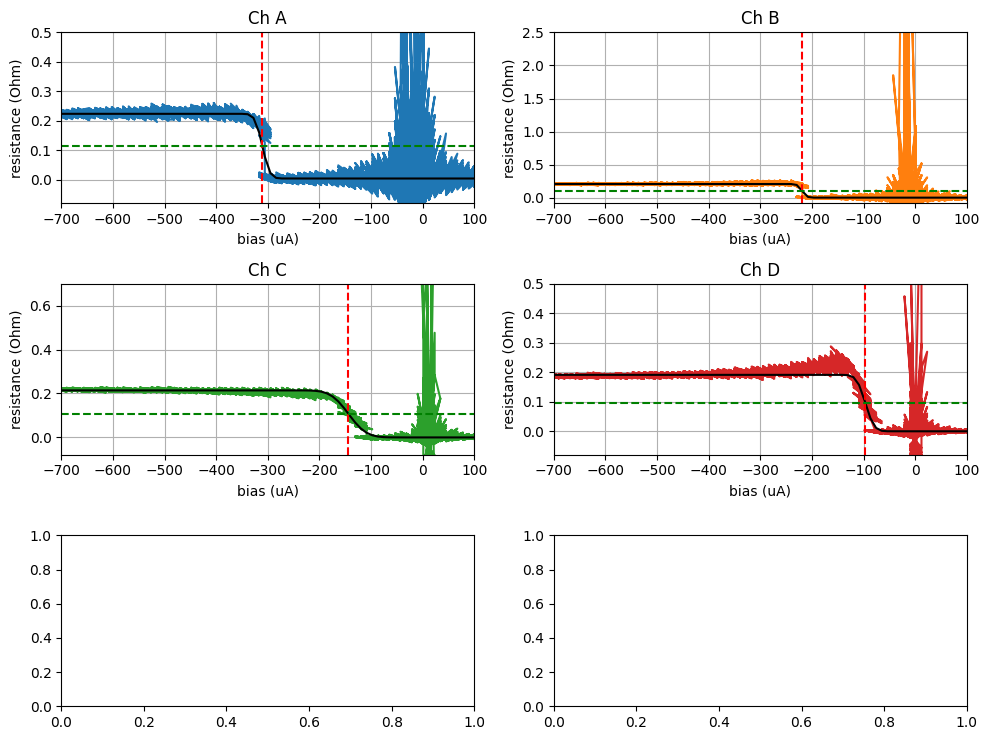

In [18]:
noise_windows = { # uA
    'A': (-40, 40),
    'B': (-25, 25),
    'C': (-30, 25),
    'D': (-35, 25),
    'E': (-35, 25)
}


#sweep_without_window = np.array([i in full_sweep for i in range(ibis.ts.size)])*(~window)

def transition_curve(x,  Rn, Rsc, loc, scale,):

    return Rsc + (Rn - Rsc)*ss.erfc((x - loc)/scale)/2

def inv_transition_curve(y, Rn, Rsc, loc, scale):

    return scale*ss.erfcinv(2*(y - Rsc)/(Rn-Rsc)) + loc

fig, axs = plt.subplots(nrows = 3, ncols = 2, figsize = (10,7.5))

popt = {}
pcov = {}


for i, (c,ax) in enumerate(zip(channels, axs.flatten())):
    ax.grid()
    ax.set_title(f'Ch {c}')


    x = ibis('H')[full_sweep]*1e3
    y = ivfits.r0[0,i][full_sweep]

    window = (x > noise_windows[c][0])*(x < noise_windows[c][1])

    xfit = x[~window]
    yfit = y[~window]


    popt[c], pcov[c] = so.curve_fit(transition_curve, xfit, yfit, p0 = (ivfits.rnorm[0,i], 0, -80, 20))

    y_opt = transition_curve(sorted(x), *popt[c])

    ax.plot(x, y, label = c, color = f'C{i}')
    #ax.plot(xfit, yfit, color = 'grey')
    ax.plot(sorted(x), y_opt, color = 'k')
    ax.set_ylim(-0.08, 0.7 if c == 'C' else (2.5 if c == 'B' else 0.5))
    ax.set_xlim(-700, 100)
    ax.set_xlabel('bias (uA)')
    ax.set_ylabel('resistance (Ohm)')

transition_fits = pd.DataFrame.from_dict(popt)
transition_fits.index = ('Rn', 'Rsc', 'loc', 'scale')

op_pt = 0.5 # operation at 35% of normal resistance

R_ops = op_pt*(transition_fits.loc['Rn'] - transition_fits.loc['Rsc']) + transition_fits.loc['Rsc']
R_ops.name = 'R_op'

op_pts = np.array([inv_transition_curve(R_ops[i], *popt[c]) for i, c in enumerate(channels)])

for i, (c,ax) in enumerate(zip(channels, axs.flatten())):
    ax.axvline(op_pts[i], color = 'r', linestyle = 'dashed')
    ax.axhline(R_ops[i], color = 'g', linestyle = 'dashed')

# add data to transition_fits
transition_fits.loc['R_op'] = R_ops # Ohm
transition_fits.loc['I0'] = op_pts # uA
transition_fits.loc['P0'] = R_ops*(op_pts**2) # pW

#plt.legend(loc = 'best')
fig.tight_layout()

In [19]:
transition_fits

,A,B,C,D
Rn,0.223463,0.210387,0.213780,0.191190
Rsc,0.003966,0.004466,-0.000885,-0.000359
loc,-310.493013,-219.072193,-143.709843,-96.461675
scale,15.935950,9.934866,38.586545,18.814231
R_op,0.113714,0.107427,0.106447,0.095415
I0,-310.493013,-219.072193,-143.709843,-96.461675
P0,10962.722112,5155.693607,2198.407237,887.825008


In [20]:
dIb90_10 = [(ss.erfcinv(2*0.1) - ss.erfcinv(2*0.9))*transition_fits[c]['scale'] for c in channels]
dIb90_10 # transition width from 10% of normal to 90% of normal

[np.float64(28.882118409746152),
 np.float64(18.00582874706937),
 np.float64(69.93377525047352),
 np.float64(34.09867872212285)]

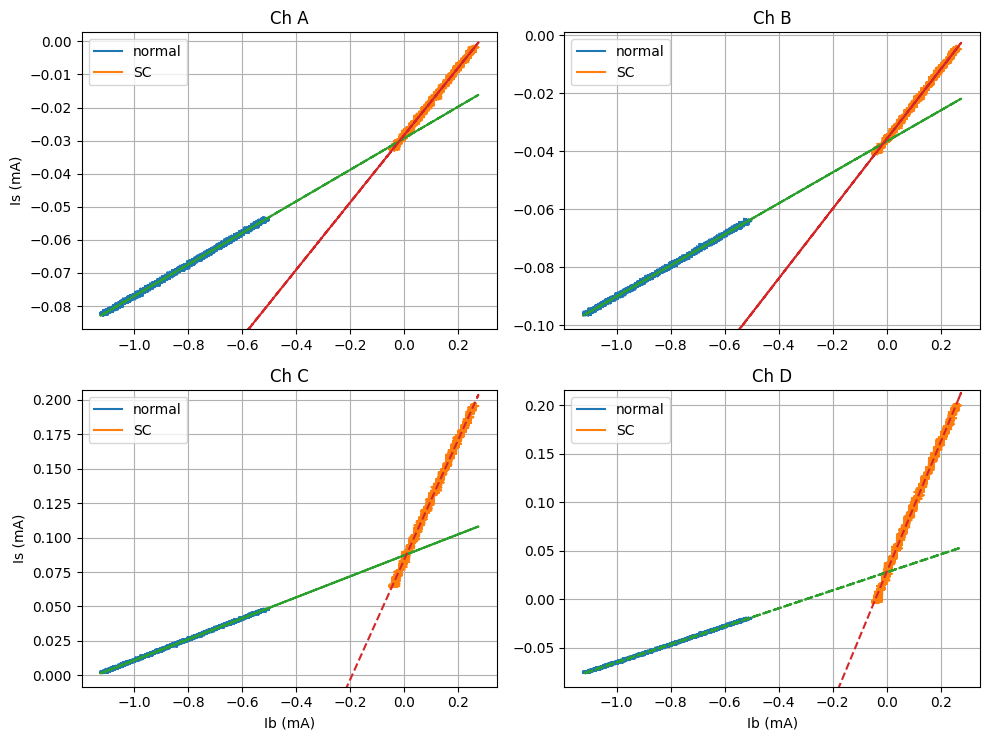

In [21]:

fig, axs = plt.subplots(nrows = 2, ncols = 2, figsize = (10,7.5))

for ax in axs[1]:
    ax.set_xlabel('Ib (mA)')
for ax in axs[:,0]:
    ax.set_ylabel('Is (mA)')

for i, c, ax in zip(range(4), channels, axs.flatten()):

    ax.grid()
    ax.set_title(f'Ch {c}')


    ax.plot(1e3*pico_to_ibias(ibis('H')[normalinds], n = len(channels)), -1e3*to_ADC(ibis(c)[normalinds], ibis.config), label = 'normal')
    ax.plot(1e3*pico_to_ibias(ibis('H')[scinds], n = len(channels)), -1e3*to_ADC(ibis(c)[scinds], ibis.config), label = 'SC')

    wind = ax.axis()

    ax.legend()

    xplot = pico_to_ibias(ibis('H')[full_sweep], n = len(channels))

    norm_fit = lambda x: ivfits.int_n[0,i,0] + ivfits.slope_n[0,i,0]*x
    sc_fit = lambda x: ivfits.int_sc[0,i,0] + ivfits.slope_sc[0,i,0]*x

    ax.plot(1e3*xplot, 1e3*norm_fit(xplot), '--')
    ax.plot(1e3*xplot, 1e3*sc_fit(xplot), '--')


    ax.axis(wind)

    #ax.plot(ibis(c)[nslice])
    #ax.plot(ibis(c)[scslice])


    wind = ax.axis()

    #ax.plot(ibis.ts, ibis(c))

    ax.axis(wind)
    

fig.tight_layout()


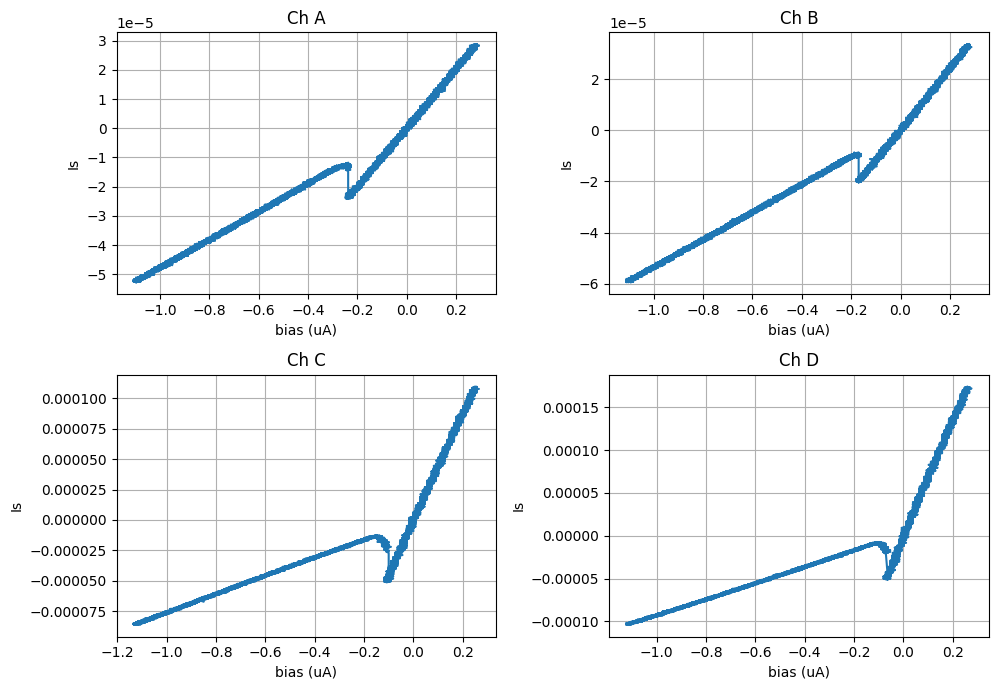

In [22]:

fig, axs = plt.subplots(nrows = numrows, ncols = 2, figsize = (10,3.5*numrows))


for i, (c, ax) in enumerate(zip(channels, axs.flatten())):

    ax.grid()
    ax.set_title(f'Ch {c}')
    ax.set_xlabel('bias (uA)')
    ax.set_ylabel('Is')


    #ax.plot(ibis('H')[normalinds], -ibis(c)[normalinds], label = 'normal')
    #ax.plot(ibis('H')[scinds], -ibis(c)[scinds], label = 'SC')
    ax.plot(ivfits.ibias_true[0,i][full_sweep]*1e3, ivfits.ites[0,i][full_sweep])

    wind = ax.axis()

    #ax.legend()

    #ax.plot(ibis('H')[full_sweep], ivfits.int_n[0,i,0] + ivfits.slope_n[0,i,0]*ibis('H')[full_sweep], '--')
    #ax.plot(ibis('H')[full_sweep], ivfits.int_sc[0,i,0] + ivfits.slope_sc[0,i,0]*ibis('H')[full_sweep], '--')


    ax.axis(wind)

    #ax.plot(ibis(c)[nslice])
    #ax.plot(ibis(c)[scslice])


    wind = ax.axis()

    #ax.plot(ibis.ts, ibis(c))

    ax.axis(wind)
    

fig.tight_layout()


In [25]:
# save results
if 1:
    # savefile = f'./ibis_data/local/{runname}_results.dat'
    savefile = f'{folder_base}/B13 Cryolab/Run{runnum}/IbIs Data/{runname}_results_doubled.dat'
    with open(savefile, 'wb') as f:
        pickle.dump(file = f, obj = (ibis, ivfits, transition_fits))
    print('saved data to', savefile)

saved data to C:/Users/MINER/Documents/B13 Cryolab/Run4/IbIs Data/20250516_results_doubled.dat


In [24]:
# IBIS object can take multiple bias points (iters), channels (chs), and different temperatures (temps)
# input array dites has shape either (niters,), (nch,niters), or (ntemps,nch,niters)
# bias vals given in ibias (should be increasing along "iters" dimension)

# read dites/ibias data from csv
#ivdf = pd.read_csv('IV.csv', index_col = 0)

#chan_names = list(ivdf.columns)
#ibias = np.expand_dims(np.stack(len(chan_names)*[ivdf.index.values]), axis = 0)
#ibias = np.stack(len(chan_names)*[ivdf.index.values], axis = 0)[np.newaxis,:]
#dites = np.array([ivdf[c].values for c in chan_names])[np.newaxis,:]

# create IBIS object
#ivdata = qp.IBIS(
#    dites = dites, # read out current from electronics (A)
#    dites_err = np.zeros(dites.shape), 
#    ibias = ibias, # TES bias current for dites measurements (A)
#    ibias_err = np.zeros(ibias.shape),
#    rsh = didv.config['rsh'], # shunt resistance of TES circuit
#    rsh_err = 0.,
#    normalinds = np.array([0,1,2]), # indices of normal resistance points in dites (will do separate normal and SC fits)
#    #rp_guess = ,
#    #rp_err_guess = ,
#    chan_names = chan_names
#)

#ivdata.analyze()
# then e.g. grab ivdata.r0 for r0 in dict below

# IBIS objects fit (Ib,Is) data (aka (ibias/dites)) to lines of the form
# Is = A*Ib + B

# ivdata.rp = parasitic resistance in TES line
# ivdata.rnorm = normal-state resistance of TES
# ivdata.rfit = total resistance rnorm + rp + Rs
# ivdata.r0 = equiv to rnorm, but accounting for shift of the "baseline" point of the normal-mode Ib/Is line (so looking at (dites - ioff) = (rsh/(rsh+rp+r0))(ibias - ibias_off) ) '
# ---> (Is - Is0) = (Rs/(Rs+Rp+Rn))(Ib - Ib0)
# ivdata.ioff = TES current offset - point where SC and normal mode lines intersect (y-coord)
# ivdata.ibias_off = bias current offset - point where SC and normal mode lines intersect (x-coord)
# ites = dites - ioff
# ibias_true = ibias - ibias_off